## Imports and Data.

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import mnist
import shutil
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# import tensorflow_probability as tfp
from random import randint

# Visualization. 
from tensorflow.contrib.tensorboard.plugins import projector
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Take train, test images.
train_images = mnist.train_images()
# train_images = train.reshape((train.shape[0], 28,28,1))
train_labels = mnist.train_labels()
test_images = mnist.test_images()
# test_images = test.reshape((test.shape[0], 28,28,1))
test_labels = mnist.test_labels()


NotFoundError: dlopen(/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/contrib/nccl/python/ops/_nccl_ops.so, 6): Symbol not found: _ncclAllReduce
  Referenced from: /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/contrib/nccl/python/ops/_nccl_ops.so
  Expected in: flat namespace
 in /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/contrib/nccl/python/ops/_nccl_ops.so

Test images: (10000, 28, 28)
Train images: (60000, 28, 28)


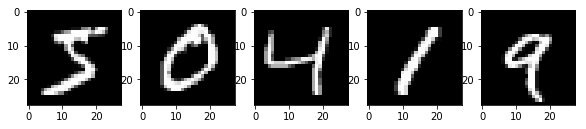

In [53]:
# Simple function to plot number images.
def plot_images(plt_num, images, dim):
    # Standard parameters for the plot.
    
    mpl.rcParams["figure.figsize"] = dim, dim
    fig = plt.figure()
    for i in range(0, plt_num):
        fig.add_subplot(1, 10, i+1)
        img = images[i,:,:]
        plt.imshow(img, cmap='gray')
        
print('Test images:', test_images.shape)
print('Train images:', train_images.shape)
plot_images(5, train_images, 20)


## Prepare Data set.

In [54]:
class Dataset:
    def __init__(self, train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=False, image_dimensions=28):
    
        self.train_img = train_images
        self.train_labels = train_labels
        self.shuffle = shuffle
        self.image_dimensions = image_dimensions
        self.projection_data_path = projection_data_path
        self.metadata_tsv = '%s/metadata.tsv' % projection_data_path
        self.sprite = '%s/sprite_train_img.png' % projection_data_path
        if self.shuffle:
            idx = np.arange(len(self.train_img))
            np.random.shuffle(idx)
            self.train_img = self.train_img[idx]
            self.train_labels = self.train_labels[idx]
        
        
        whole_train = len(train_images)
        num_validation_samples = int(whole_train*validation)
        num_train_sample = whole_train - num_validation_samples
        
        
        self.train_img = self.train_img[:num_train_sample,:,:]
        self.train_img = self.prepare_data(self.train_img)
        self.train_labels = self.train_labels[:num_train_sample]
        
        self.test_img = self.prepare_data(test_images)
        self.test_labels = test_labels
        
        if not validation == 0.0:
            self.validation_labels = self.train_labels[num_train_sample+1:]
            self.validation_img = self.train_img[num_train_sample+1:,:,:]
            self.validation_img = self.prepare_data(self.validation_img)        
        
    def flatten(self, images):
        return images.reshape((images.shape[0], -1))
    
    def reshape(self, images):
        return np.reshape(images, (images.shape[0], self.image_dimensions, self.image_dimensions))
    
    def normalize(self, images):
        # Normalize.
        max_value = np.amax(images)
        post = images/max_value
        return post
    
    # Function to pre-process the data.
    def prepare_data(self, images):
        # Reshape data, flattening.
        post_images = self.normalize(images)
#         post_images = self.flatten(post_images)
        return post_images
    
    def batches(self, batch_size):
        n_batches = len(self.train_img)//batch_size
        for index in range(0, n_batches, batch_size):
            x = self.train_img[index:index+batch_size]
            y = self.train_labels[index:index+batch_size]
            yield x, y

    def random_test(self):
        idx = np.arange(len(self.test_img))
        np.random.shuffle(idx)
        return [self.test_img[idx[0], :, :]]
    
    def random_train(self):
        idx = np.arange(len(self.train_img))
        np.random.shuffle(idx)
        return [self.train_img[idx[0], :, :]]
    
    def create_sprite_image(self, images):
        
        if os.path.isfile(self.sprite):
            os.remove(self.sprite)
        
#         images = 1-images
        img_h = images.shape[1]
        img_w = images.shape[2]
        n_plots = int(np.ceil(np.sqrt(images.shape[0])))

        spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))

        for i in range(n_plots):
            for j in range(n_plots):
                this_filter = i * n_plots + j
                if this_filter < images.shape[0]:
                    this_img = images[this_filter]
                    spriteimage[i * img_h:(i + 1) * img_h, j * img_w:(j + 1) * img_w] = this_img
        plt.imsave(self.sprite, spriteimage,cmap='gray')

    def create_tsv_file(self, img_labels):
        if os.path.isfile(self.metadata_tsv):
            os.remove(self.metadata_tsv)
        
        with open(self.metadata_tsv,'w') as f:
            f.write("Index\tLabel\n")
            for index,label in enumerate(img_labels):
                f.write("%d\t%d\n" % (index,label))
                

## Encoder Qphi(Z/X) & Decoder Ptheta(X/Z)

In [55]:
class CVAE():
    def __init__(self, dim_img, dim_x, dim_z, hidden_dim, learning_rate, latent_samples=1):
        
        # Shape=(Batch_size, dim_x).
        self.learning_rate = learning_rate
        self.latent_samples = latent_samples
        self.x_input = tf.placeholder(shape=(None, dim_img, dim_img), dtype=tf.float32, name='input_image')
        self.y_input = tf.placeholder(shape=(None, 1), dtype=tf.float32, name='input_label')
        self.y_gen = tf.placeholder(shape=(None, 1), dtype=tf.float32, name='input_label_gen')
        self.z_input = tf.placeholder(shape=(None, dim_z), dtype=tf.float32, name='input_latent')
        self.vae_loss, self.vae_opt = self.model(self.x_input, self.z_input, self.y_input, self.y_gen, dim_img, dim_x, dim_z, hidden_dim, name='model')
        
        # Tensorboard scalars and images.
        tf.summary.scalar('vae_loss', self.vae_loss)
        tf.summary.scalar('kl_divergence', self.kl_divergence)
        tf.summary.scalar('sampling_expt', self.sampling_expt)
        tf.summary.image('Input_Image_X', tf.reshape(self.x_input*255, (-1, dim_img, dim_img, 1)))
        tf.summary.image('Reconstruction', tf.cast(tf.reshape(self.p_x_given_z_recon*255, (-1, dim_img, dim_img, 1)), dtype=tf.float32))
        tf.summary.histogram("Encoder/Mean", self.mean_z_g_xi)
        tf.summary.histogram("Encoder/Sigma", self.sigma_z_g_xi)
        tf.summary.histogram("Z_sample", self.z_sample_xi)
        tf.summary.histogram("Generator/Mean", self.mean_x_g_zi)
        tf.summary.histogram("Generator/LogSigmaSquare", self.logs2_xi_given_z)
        
        self.merged_summary_op = tf.summary.merge_all()
        
        # Variable initializer.
        self.init = tf.global_variables_initializer()
        
    def encoder(self, images, labels, dim_z, hidden_dim, reuse, name):
        
        with tf.variable_scope(name_or_scope=name, reuse=reuse) as scope:
            # X Shape (Batch_size, dim_x).
            x_flatten = tf.layers.flatten(inputs=images, name='flattening')
            input_concat = tf.concat([x_flatten, labels], axis=-1)
            
            # Hidden Layer (Batch_size, dim_hidden).
            hidden_qphi_1 = tf.layers.dense(inputs=input_concat, units=hidden_dim, activation=tf.nn.relu, name='hidden_layer_qphi_1')
            
            # Mean & Sigma, positive numbers softplus on the latter since it cannot be negative. 
            # Output Shape = (Batch_size, dim_z).
            mean_z_given_xi = tf.layers.dense(inputs=hidden_qphi_1, units=dim_z, activation=None, name='mean_z_given_xi')
            sigma_z_given_xi = tf.layers.dense(inputs=hidden_qphi_1, units=dim_z, activation=tf.nn.softplus, name='sigma_z_given_xi')
        return mean_z_given_xi, sigma_z_given_xi

    
    def decoder(self, z_sample_given_xi, labels, dim_img, dim_x, hidden_dim, reuse, name):
        
        with tf.variable_scope(name_or_scope=name, reuse=reuse) as scope:
            # Input Layer (Batch_size, dim_z).
            input_concat = tf.concat([z_sample_given_xi, labels], axis=-1)
            
            # Hidden Layer (Batch_size, dim_hidden).
            hidden_ptheta_1 = tf.layers.dense(inputs=input_concat, units=hidden_dim, activation=tf.nn.relu, name='hidden_layer_ptheta_1')
            
            # Need to introduce tf.contrib.distributions.Independent() to tell tensorflow that the hight and Width dimensions belong to the same data point.  
            # For CNN, here we are just reshaping.
            mean_xi_given_z = tf.layers.dense(inputs=hidden_ptheta_1, units=dim_x, activation=tf.nn.sigmoid, name='mean_xi_given_z')
            logs2_xi_given_z = tf.layers.dense(inputs=mean_xi_given_z, units=dim_x, activation=tf.nn.softplus, name='logs2_xi_given_z')
            mean_xi_given_z = tf.reshape(tensor=mean_xi_given_z, shape=(-1, dim_img, dim_img))
            logs2_xi_given_z = tf.reshape(tensor=logs2_xi_given_z, shape=(-1, dim_img, dim_img))
            
        return mean_xi_given_z, logs2_xi_given_z

    
    def model(self, x_input, z_input, y_input, y_gen, dim_img, dim_x, dim_z, hidden_dim, name):
        with tf.variable_scope(name) as scope:
            
            ## ENCODER.
            # Mean and Sigma from datapoint Xi. Shape = (Batch_size, dim_z).
            # In the encoder, the neural network is able to approximate fairly well the s.t.d. for the latent space of the given sample Xi.
            self.mean_z_g_xi, self.sigma_z_g_xi = self.encoder(x_input, y_input, dim_z, hidden_dim, reuse=False, name='Qphi_z_given_x')
            
            # PARAMETRIZATION TRICK.
            # Building Normal distribution and pushes mean, scale s.t.d.
            # Makes sure that Tensorflow takes into account that mean and sigma are parameter so it propagates gradients. 
            q_z_given_x = tfp.distributions.MultivariateNormalDiag(loc=self.mean_z_g_xi, scale_diag=self.sigma_z_g_xi)
            assert q_z_given_x.reparameterization_type == tfp.distributions.FULLY_REPARAMETERIZED
            # Get sample Z from the conditional distribution given Xi.
            # Shape = (Batch_size, dim_z).
            # Each dim z r.v is independent from each other, we assume that the covariance between them is 0.
            self.z_sample_xi = q_z_given_x.sample()
            
            
            # Modeling P(z) as a Normal distribution.
            # Shape = (Batch_size, dim_z).
            location = tf.zeros_like(self.mean_z_g_xi)
            scale = tf.ones_like(self.sigma_z_g_xi)
            self.p_z = tfp.distributions.MultivariateNormalDiag(loc=location, scale_diag=scale)
            
            
            # DECODER.
            # Shape = (Batch_size, dim_x).
            self.mean_x_g_zi, self.logs2_xi_given_z = self.decoder(self.z_sample_xi, y_input, dim_img, dim_x, hidden_dim, reuse=False, name='Ptheta_x_given_x')
            self.p_x_given_z_recon = self.mean_x_g_zi
            
            # DISTRIBUTIONS FOR ENCODER.
            # 1. Gassian.
            # Important Note: If we use the NN to approximate the s.t.d. the error in approximation will introduce noise and scale it when you doing the log_prob,
            # since this s.t.d. will go into a log, with a lower value than one scaling the approximation problem.
            # The solution to this is to introduce directly the approximation error with log(sigma**2).
            # Furhter insight into this, not only the neural network is introducing the error int the approximation, since me approximate with the sample on the 
            # latent space, this is also introduces an error than is later magnified by the NN and the log function.
#             p_x_given_z = tfp.distributions.Independent(tfp.distributions.MultivariateNormalDiag(loc=self.mean_x_g_zi, scale_diag=self.sigma_xi_given_z))
#             assert p_x_given_z.reparameterization_type == tfp.distributions.FULLY_REPARAMETERIZED
            
            # 2. Bernoulli
#             p_x_given_z = tfp.distributions.Independent(tfp.distributions.Bernoulli(logits=self.mean_x_g_zi), reinterpreted_batch_ndims=2).
#             self.p_x_given_z_recon = p_x_given_z.sample().
        
            
            # ELBO: Building lower bound, the intent is to maximize this so the log(P(Xi)) maximizes.
            # 1st Term: KL Divergence: Q(Z/X) and P(Z).
            # Careful here with the balance on the reduce_sum/mean.
            self.kl_divergence = tf.reduce_sum(tfp.distributions.kl_divergence(distribution_a=q_z_given_x, distribution_b=self.p_z), axis=-1)
#             kl= -tf.reduce_sum(.5*(1 + self.logs2_z_given_xi - (self.mean_z_g_xi**2) - tf.exp(self.logs2_z_given_xi)), axis=-1)
#             self.kl_divergence = tf.reduce_sum(kl, axis=-1)
            
            # 2nd Term: Expectation error of the decoder form the encoder. 
            # With Bernoulli has decoder, we can use prob_lob, usign the Gaussian forces to use the analytical to avoid the error scaling from log and s.t.d.
            
            # 2.A. Gaussian:
            exp_ls2 = ((self.x_input - self.mean_x_g_zi)**2)/tf.exp(self.logs2_xi_given_z)
            se = tf.log(2*np.pi) + self.logs2_xi_given_z + exp_ls2
            se = tf.reduce_sum(-.5*se, axis=[1,2])
            self.sampling_expt = tf.reduce_sum(se, axis=-1)

            # 2.B. Berboulli:
#             self.sampling_expt = tf.reduce_sum(p_x_given_z.log_prob(self.x_input), axis=-1)

            # We try to maximize the lower bound, so our objective is to minimize our loss.
            elbo = -self.kl_divergence + self.sampling_expt
            vae_loss = -elbo
            vae_opt = tf.train.AdamOptimizer(self.learning_rate).minimize(vae_loss)
            
            # Generator to sample.
            # Shape = (Batch_size, dim_x).
            self.generated_mean, self.generated_logs2 = self.decoder(z_input, y_gen, dim_img, dim_x, hidden_dim, reuse=True, name='Ptheta_x_given_x')
        
        return vae_loss, vae_opt
    

In [66]:
# Auxiliary function to plot generated digits.
def plot_samples(vae, sess, lat_img_run, e):
    images = 36
    
    # Normal distribution to generate images.
    location = tf.zeros((1, dim_z))
    scale = tf.ones((1, dim_z))
    normal = tfp.distributions.MultivariateNormalDiag(loc=location, scale_diag=scale)
    z_input = np.array(normal.sample(images).eval())
    z_input = z_input[:, 0, :]
    labels = np.array([randint(0, 9) for i in range(images)]).reshape((-1,1))
    
    generated = sess.run(vae.generated_mean, feed_dict={vae.z_input: z_input, vae.y_gen: labels})
    
    n_sqrt = int(np.sqrt(generated.shape[0]))
    fig, axes = plt.subplots(n_sqrt, n_sqrt, sharex=True, sharey=True, figsize=(n_sqrt*3, n_sqrt*3))
    for ii, ax in zip(range(0, generated.shape[0]), axes.flatten()):
        ax.imshow(generated[ii, :, :]*255, aspect='equal', cmap='gray')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig( '%s/%s.png' % (lat_img_run, e))
    plt.close()
    
    

## Parameters.

In [67]:
show_every = 1000
show_latent = 250

distribut = 'Gaussian'
layers = 1


batch_size = 64
dim_img = 28
dim_x = dim_img**2
dim_z = 6
hidden_dim = 500
lr = 1e-3
epochs = int(1e4)

run_name = '%s-%s-layer-full-bs_%s_dimz_%s_dimh_%s_lr_%s' % (distribut, layers, batch_size, dim_z, hidden_dim, lr)
projection_data_path = '/Users/aclaudioquiros/Documents/PycCharm/UofG/PhD/MnistVAE/CVAE/'
tensorboard_path = '/Users/aclaudioquiros/Documents/PycCharm/UofG/PhD/MnistVAE/CVAE/tensorboard'
latent_images = '/Users/aclaudioquiros/Documents/PycCharm/UofG/PhD/MnistVAE/CVAE/latent_images'
tb_session = '%s/%s' % (tensorboard_path, run_name)
lat_img_run = '%s/%s' % (latent_images, run_name)


if os.path.isdir(tb_session):
    shutil.rmtree(tb_session)
if os.path.isdir(lat_img_run):
    shutil.rmtree(lat_img_run)
os.makedirs(tb_session)
os.makedirs(lat_img_run)


tf.reset_default_graph()
vae = CVAE(dim_img=dim_img, dim_x=dim_x, dim_z=dim_z, hidden_dim=hidden_dim, learning_rate=lr)
data = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path)

iteration = 0
with tf.Session() as sess:
    
    summary_writer = tf.summary.FileWriter(tb_session, graph_def=sess.graph_def)
    sess.run(vae.init)    
    for e in range(epochs+1):
        for images, labels in data.batches(batch_size):
            
            labels = np.reshape(labels, (-1, 1))
                
            # Train and store data 
            sess.run(vae.vae_opt, feed_dict={vae.x_input: images, vae.y_input: labels})
            summary_str, vae_loss, vae_mean_z_g_xi = sess.run([vae.merged_summary_op, vae.vae_loss, vae.mean_z_g_xi], feed_dict={vae.x_input: images, vae.y_input: labels})
            summary_writer.add_summary(summary_str, iteration)
            
            if iteration%show_every==0:
                # Run batch and print loss.
                print('Epoch %s/%s... VAE Loss: %s' % (str(e), str(epochs), str(vae_loss)))
            iteration += 1
            
        if e%show_latent == 0:
            plot_samples(vae, sess, lat_img_run, e)

#     data.create_sprite_image(data.test_img)
#     data.create_tsv_file(data.test_labels)
#     mean_z_g_xi = sess.run(vae.mean_z_g_xi, feed_dict={vae.x_input: data.test_img})
#     latent = tf.Variable(mean_z_g_xi, name='Latent_Space_Z_%s' % e)
    
#     saver = tf.train.Saver([latent])
#     sess.run(latent.initializer)
#     saver.save(sess, os.path.join(tb_session, 'latent_%s.ckpt' % e))
#     config = projector.ProjectorConfig()
#     embedding = config.embeddings.add()
#     embedding.tensor_name = latent.name
#     embedding.sprite.image_path = data.sprite
#     embedding.sprite.single_image_dim.extend([28,28])
#     embedding.metadata_path = data.metadata_tsv
    
#     projector.visualize_embeddings(summary_writer, config)


Epoch 0/10000... VAE Loss: 63256.54
Epoch 66/10000... VAE Loss: 47280.92
Epoch 133/10000... VAE Loss: 47140.844
Epoch 200/10000... VAE Loss: 47145.195
Epoch 266/10000... VAE Loss: 47173.266
Epoch 333/10000... VAE Loss: 47065.523
Epoch 400/10000... VAE Loss: 47093.71
Epoch 466/10000... VAE Loss: 47082.996
Epoch 533/10000... VAE Loss: 47053.66
Epoch 600/10000... VAE Loss: 47089.25
Epoch 666/10000... VAE Loss: 47042.29
Epoch 733/10000... VAE Loss: 46986.387
Epoch 800/10000... VAE Loss: 47048.375
Epoch 866/10000... VAE Loss: 47029.12
Epoch 933/10000... VAE Loss: 46995.6
Epoch 1000/10000... VAE Loss: 46984.547
Epoch 1066/10000... VAE Loss: 46986.883
Epoch 1133/10000... VAE Loss: 46960.387
Epoch 1200/10000... VAE Loss: 47018.41
Epoch 1266/10000... VAE Loss: 46993.69
Epoch 1333/10000... VAE Loss: 46960.434
Epoch 1400/10000... VAE Loss: 46992.664
Epoch 1466/10000... VAE Loss: 46973.71
Epoch 1533/10000... VAE Loss: 46974.87
Epoch 1600/10000... VAE Loss: 46992.297
Epoch 1666/10000... VAE Loss: 4